In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json

import os
from typing import List, Tuple, Union


from scipy.io import loadmat,savemat
import matplotlib.pyplot as plt



from statesim.analysis import plot_simulation_results as plot
from statesim.system import pendulum, coupled_msd
from statesim.configuration import GenerateConfig
from statesim.simulator import ContinuousSimulator
from statesim.model.statespace import Nonlinear

from crnn.configuration.experiment import load_configuration, ExperimentConfig, ExperimentTemplate
from crnn.models.model_io import get_model_from_config, load_model
from crnn.additional_tests import InputOutputStabilityL2, retrieve_additional_test_class, AdditionalTestConfig, StabilityOfInitialState
from crnn.tracker.io import IoTracker
from crnn.utils import base as utils
from crnn.data_io import load_normalization
from crnn.utils.base import get_sequence_norm

import torch
torch.set_default_dtype(torch.double)

from dataclasses import asdict



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load true system

In [2]:
# pendulum
# config_file_name = '/Users/jack/actuated_pendulum/data/nonlinear-initial_state-0_M-500_T-10/raw/config.json'
# coupled msd
config_file_name = '/Users/jack/coupled-msd/data/coupled-msd-routine/raw/config.json'
with open(config_file_name, 'r') as f:
    data_config = json.load(f)

data_config = GenerateConfig(**data_config)
noise_config = data_config.measurement_noise
N = int(data_config.T / data_config.step_size)

# sys = pendulum.ActuatedPendulum()
sys = coupled_msd.CoupledMsd()
model = Nonlinear(
    sys.state_dynamics,
    sys.output_function,
    sys.nx,
    sys.ny,
    sys.nu
)
dt = data_config.step_size

# load model

In [18]:

# data_file_name = '/Users/jack/cloud_privat/03_Promotion/_transfer/P-32-joint-lstm/seq/test_output-stability_l2-nonlinear-initial_state-0_M-500_T-10.mat'

# result_root_directory = '/Users/jack/cloud_privat/03_Promotion/_transfer/'
result_root_directory = '/Users/jack/coupled-msd/2024_12_12-cRnn'
# m_e_config_file_name = '/Users/jack/cloud_privat/03_Promotion/_transfer/actuated_pendulum.json'
m_e_config_file_name = '/Users/jack/coupled-msd/2024_12_12-cRnn/coupled-msd.json'

b, num_layer = 1,2
# m_e_name = 'P-32-joint-lstm'
# m_e_names = {'MSD-32-joint-lstm', 'MSD-16-joint-tanh', 'MSD-16-joint-dzn', 'MSD-16-joint-dznGen'}
# m_e_names = {'MSD-128-zero-dual-lstm', 'MSD-16-zero-dual-rnn','MSD-16-zero-dual-sat'}
experiment_names = ['MSD-128-zero-dual', 'MSD-16-zero-dual']
model_names = ['lstm', 'sat']
e_m_names = []

config = load_configuration(m_e_config_file_name)
initializers, predictors = [], []
for e_name, m_name in zip(experiment_names, model_names):
    experiment_config = config.experiments[e_name]
    e_m_name = f"{e_name}-{m_name}"
    e_m_names.append(e_m_name)
    model_config = config.models[e_m_name]
    
    initializer, predictor = get_model_from_config(model_config)
    initializer, predictor = load_model(
            experiment_config, initializer, predictor, e_m_name, os.path.join(result_root_directory, e_m_name)
    )
    initializers.append(initializer)
    predictors.append(predictor)



# Evaluation


In [60]:
h = 200
test_config = AdditionalTestConfig(epochs=500, horizon=h, lr=0.01, sampling_type='optimize', scale=0.1)

## l2 stability

In [61]:
ds = []
results = []
for predictor, name in zip(predictors, e_m_names):
    normalization = load_normalization(os.path.join(result_root_directory,name))
    test = InputOutputStabilityL2(test_config,predictor)
    res = test.test()
    results.append(res)
    print(f'{name} \t emp. l2-gain: {res.value}')
    d = res.input_output[0].d
    ds.append(d)





MSD-128-zero-dual-lstm 	 emp. l2-gain: 11.515300708684304
MSD-16-zero-dual-sat 	 emp. l2-gain: 2.344018076219783


In [55]:
from scipy.io import loadmat
additional_test_name = 'stability_l2'
dataset_name = 'coupled-msd-routine'
B = 1

e_hats = []
e_hats_torch = []
ds_torch = []
ds = []
Ts = []
for predictor,e_m_name, e_name in zip(predictors,e_m_names,experiment_names):
    normalization = load_normalization(os.path.join(result_root_directory,e_m_name))
    # load inputs
    io_data_dict = loadmat(os.path.join(result_root_directory,e_m_name,"seq", f'test_output-{additional_test_name}-{dataset_name}'))
    d = io_data_dict['d'].reshape(B,-1,predictor.nd)
    
    
    d_sim = [d_k.reshape(predictor.nd, 1) for d_k in d[0]]
    T = d.shape[1] * dt
    Ts.append(T)
    ds.append(d_sim)

    d = torch.tensor(d)
    ds_torch.append(d)
    e_hats_c = []
    e_hats_i_torch = []
    for predictor_c, e_m_name_c in zip(predictors, e_m_names):    
        e_hat_i, _ = predictor_c.forward(d)
        e_hats_i_torch.append(e_hat_i)
        e_hats_i = utils.denormalize(
            [e_hat_i.detach().numpy()], normalization.output.mean, normalization.output.std
        )
        e_hats_c.append(e_hats_i[0][0])

    e_hats.append(e_hats_c)
    e_hats_torch.append(e_hats_i_torch)


In [58]:
len(e_hats_torch[0])


2

In [20]:
T = h*dt
sim = ContinuousSimulator(T=T, step_size=data_config.step_size)

results = []
for us, T in zip(ds,Ts):
    results.append(sim.simulate(
        model=model,
        initial_state=np.array(data_config.simulator.initial_state).reshape(
            data_config.system.nx, 1
        ),
        input=us,
    ))


---MSD-128-zero-dual-lstm---
torch.Size([1, 200, 1])
MSD-128-zero-dual-lstm 	 ga2: 7.206418357843969
torch.Size([1, 200, 1])
MSD-16-zero-dual-sat 	 ga2: 0.6260663509250265
---MSD-16-zero-dual-sat---
torch.Size([1, 200, 1])
MSD-128-zero-dual-lstm 	 ga2: 3.0939761944500423
torch.Size([1, 200, 1])
MSD-16-zero-dual-sat 	 ga2: 2.344018076219781


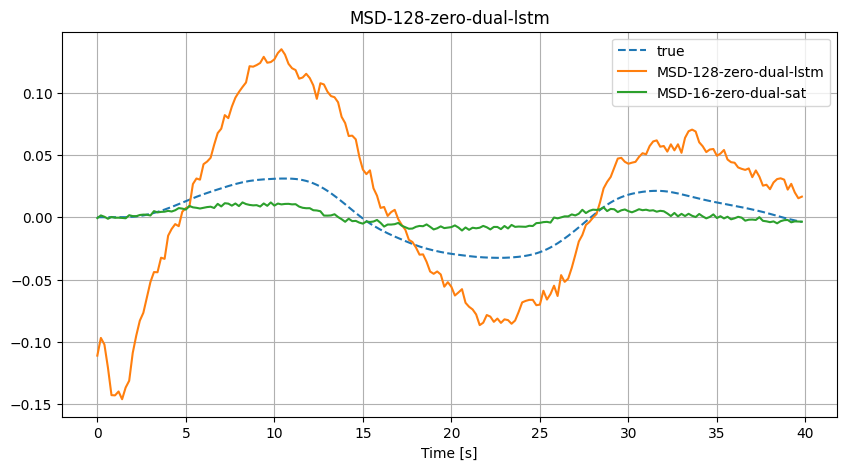

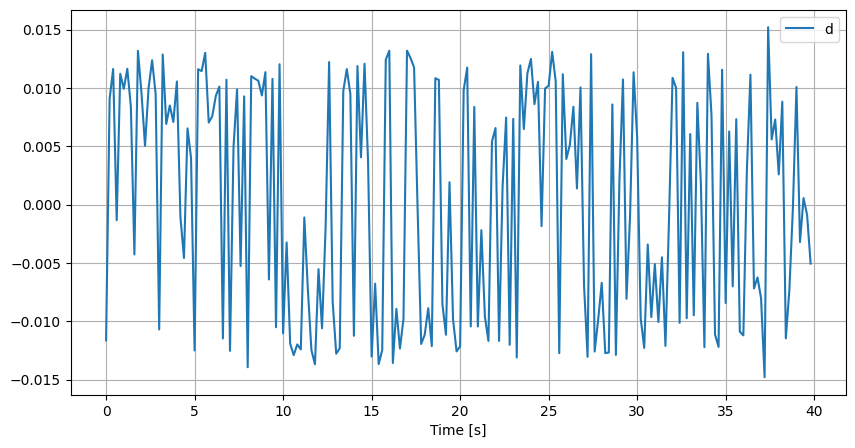

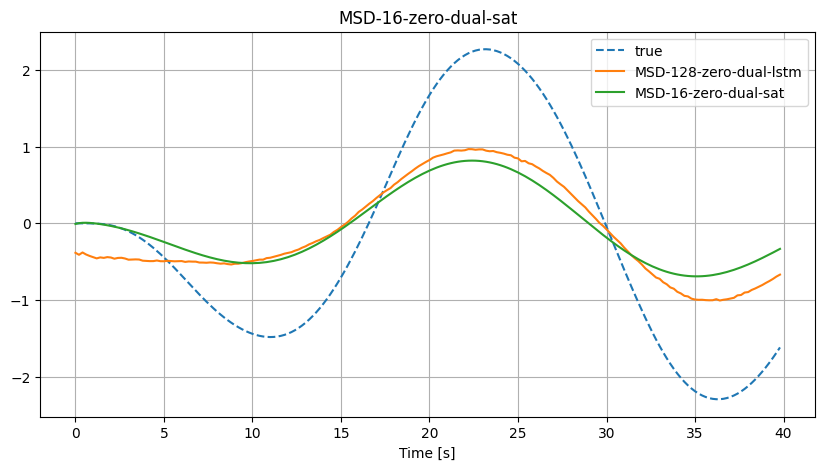

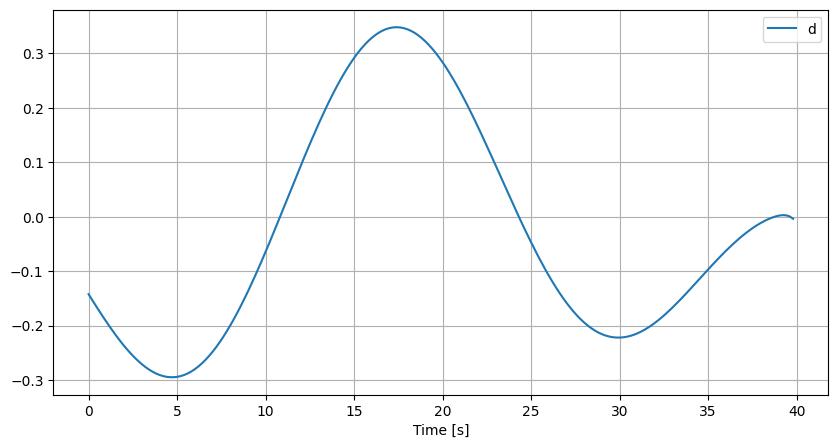

In [59]:
import tikzplotlib
embedding_directory = os.path.join(result_root_directory, '_for_embedding')
os.makedirs(embedding_directory, exist_ok=True)

for e_m_name, sim_res, e_hat_c, d_torch, e_hat_torch in zip(e_m_names, results, e_hats, ds_torch, e_hats_torch):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sim_res.t, np.vstack(sim_res.ys),'--', label='true')

    print(f'---{e_m_name}---')
    for name_c, e_hat, e_hat_i_torch in zip(e_m_names, e_hat_c, e_hat_torch):
        print(e_hat_i_torch.shape)
        print(f'{name_c} \t ga2: {torch.sqrt(get_sequence_norm(e_hat_i_torch)/get_sequence_norm(d_torch))}')
        # ax.plot(sim_res.t, e_hat, label=name_c)
        ax.plot(sim_res.t, e_hat_i_torch[0,:,:].detach().numpy(), label=name_c)
        
    ax.set_xlabel('Time [s]')
    ax.legend()
    ax.set_title(e_m_name)
    ax.grid()

    tikzplotlib.save(os.path.join(embedding_directory, 'critical_l2_output.tex'))

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sim_res.t, np.vstack(sim_res.us), label='d')
    ax.grid()
    ax.legend()
    ax.set_xlabel('Time [s]')

    tikzplotlib.save(os.path.join(embedding_directory, 'critical_l2_input.tex'))

## Generate random initial conditions and simulate true system
Evaluate convergence property

In [33]:
T = h*dt
sim = ContinuousSimulator(T=T, step_size=config.step_size)

es = []
for i in range(100):
    result = sim.simulate(
        model=model,
        initial_state=np.random.randn(sys.nx, 1),
        input=[d_k.reshape(sys.nu,1) for d_k in np.zeros((h, sys.nu))],
    )
    es.append(result.ys)

es_numpy = np.stack(es)
m = es_numpy.mean(axis=0)
std = es_numpy.std(axis=0)
mi = es_numpy.min(axis=0)
ma = es_numpy.max(axis=0)

t = np.linspace(0, (h-1)*dt, h)
fig, ax = plt.subplots(figsize=(10, 5))
for e in es:
    ax.fill_between(t, mi[:,0,0], ma[:,0,0], alpha=0.2)
    ax.plot(t, m[:,0])
ax.set_xlabel('Time [s]')
ax.grid()

AttributeError: 'ExperimentConfig' object has no attribute 'step_size'

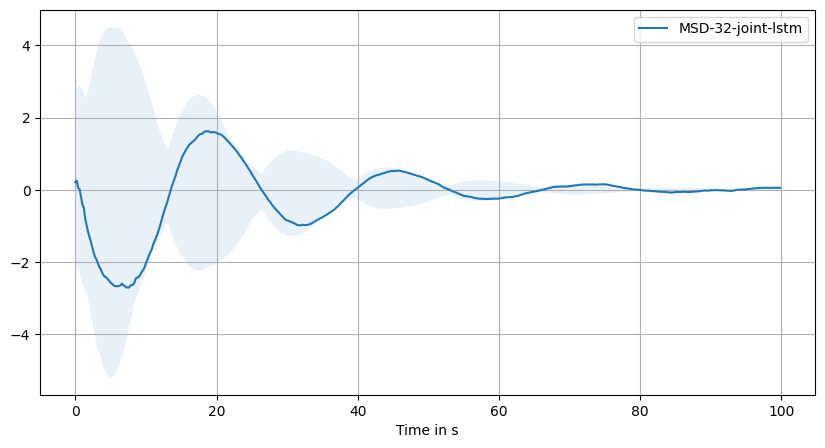

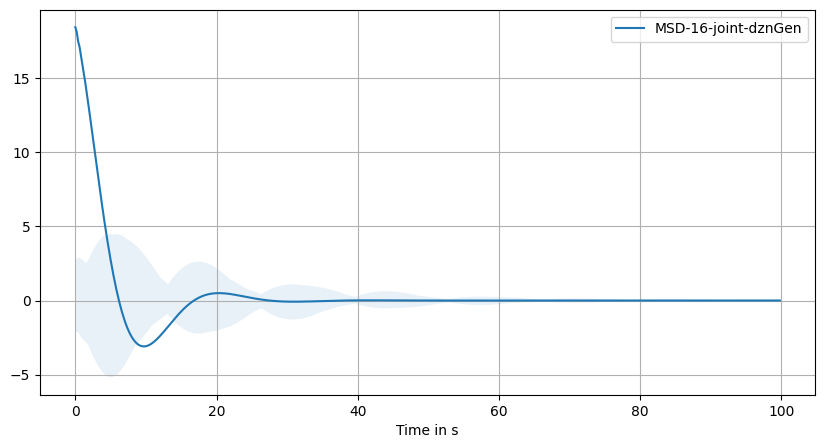

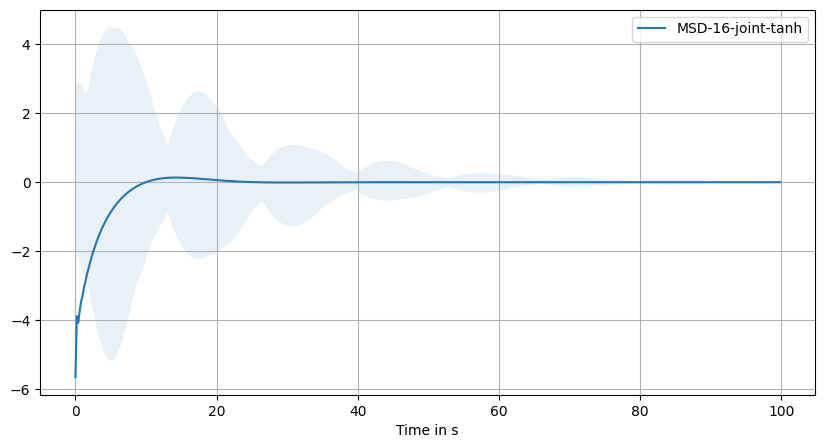

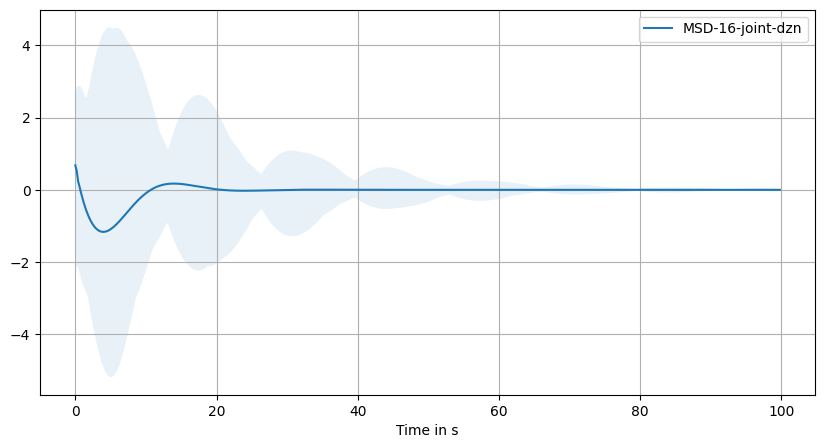

In [44]:

for name, e_hat in zip(e_m_names, x0_ehats):
    t = np.linspace(0, (h-1)*dt, h)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.fill_between(t, mi[:,0,0], ma[:,0,0], alpha=0.1)
    ax.plot(t, e_hat, label=name)
    # ax.plot(t, res_testX0.input_output[0].e_hat[0],'--', label='e_hat return')
    ax.set_xlabel('Time in s')
    ax.grid()
    ax.legend()
# torch.tensor(res_testX0.input_output[0].x0.reshape()).shape

## initial state

In [39]:
x0_ehats = []
for predictor in predictors:

    testX0 = StabilityOfInitialState(test_config, predictor, IoTracker())
    res_testX0 = testX0.test()
    x0 = [torch.tensor(x0_i) for x0_i in res_testX0.input_output[0].x0]
    h = 500
    d = torch.zeros(b,h,predictor.nd)
    e_hat, _ = predictor.forward(d,x0)
    x0_ehats.append(e_hat[0].detach().numpy())


0/1000: xk norm: 379.80, e_hat norm 5.16
1/1000: xk norm: 382.02, e_hat norm 5.17
2/1000: xk norm: 382.37, e_hat norm 5.24
3/1000: xk norm: 384.67, e_hat norm 5.69
4/1000: xk norm: 385.76, e_hat norm 5.70
6/1000: xk norm: 387.55, e_hat norm 6.11
17/1000: xk norm: 389.04, e_hat norm 6.13
34/1000: xk norm: 389.40, e_hat norm 6.35
36/1000: xk norm: 389.44, e_hat norm 6.24
41/1000: xk norm: 392.94, e_hat norm 6.31
80/1000: xk norm: 394.96, e_hat norm 7.21
87/1000: xk norm: 395.06, e_hat norm 7.46
118/1000: xk norm: 396.87, e_hat norm 7.62
159/1000: xk norm: 396.91, e_hat norm 8.11
164/1000: xk norm: 397.20, e_hat norm 8.14
174/1000: xk norm: 398.10, e_hat norm 8.01
195/1000: xk norm: 400.98, e_hat norm 7.79
216/1000: xk norm: 401.00, e_hat norm 7.75
261/1000: xk norm: 401.96, e_hat norm 8.24
274/1000: xk norm: 403.58, e_hat norm 8.62
327/1000: xk norm: 403.74, e_hat norm 8.57
337/1000: xk norm: 403.87, e_hat norm 8.67
352/1000: xk norm: 403.91, e_hat norm 8.85
354/1000: xk norm: 404.20, e_

KeyboardInterrupt: 